# Using Latent Semantic Analysis (LSA) for Continued Exploratory Data Analysis and Preliminary Modeling with  KNN to Establish Baseline Accuracy

_This notebook will apply Latent Semantic Analysis (LSA) on the data for continued exploratory data analysis, particularly in seeing which words have high interaction with each other, and for basic primer modeling, especially with the benefits of dimensionality reduction. The resulting dataframe will be saved for further modeling purposes, but I will be applying a KNN model to the data._

_Furthermore, I have decided to use the joined dataset (where titles and selftexts are combined into one text entry) because I feel that properties that exist on the title and selftext datasets are a subset of the properties on the joined dataset._

In [16]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# Reading the dataset
join = pd.read_csv('./datasets/joined.csv')
join.head()

,selftext,subreddit,title,joined
0,Wife: (sobbing) You can't do this to me! Husba...,0,Husband was screwing his secretary up the ass ...,Husband was screwing his secretary up the ass ...
1,Batman doesn't want to get shot. Why does Robi...,0,Why does Batman wear Dark clothing?,Why does Batman wear Dark clothing? Batman doe...
2,"Guilty , said the man in the dock. At this po...",0,"A man is in court. The Judges says, on the 3rd...","A man is in court. The Judges says, on the 3rd..."
3,"As she rummaged through her dusty belongings, ...",0,A poor old lady was forced to sell her valuabl...,A poor old lady was forced to sell her valuabl...
4,Dress her up as a choir boy.,0,How do you get a nun pregnant?,How do you get a nun pregnant? Dress her up as...


In [18]:
# Assigning target
target = join['subreddit']

In [19]:
# Dropping selftext and title columns
df = join.drop(['selftext','title'], axis=1)

### Adding stopwords to the ntlk stopwords corpus

In [20]:
# Importing nltk's English stop words
# Note: Using CamelCase to prevent overwriting variable later
stopWords = stopwords.words('english')

In [21]:
# From the EDA, I concluded that the following words were very common 
# in both /r/Jokes and /r/AntiJokes and were added noise. 
# I added these words to the nltk stop words
stopWords.extend(['wa', 'say', 'said', 'did', 'like', 'asked', 'woman', 
                  'don', 'know', 'year', 'wife', 'good', 'want', 'got', 
                  'ha', 'people', 'make', 'tell', 'didn', 'joke', 'x200b', 
                  'way', 'think', 'walk', 'll', 'home', 't'])

In [22]:
stopWords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Tokenizing, Lemmatizing

In [23]:
# Tokenizing by alphanumeric characters
tokenizer = RegexpTokenizer('\w+')

# Making all tokens lowercase
tokens = [tokenizer.tokenize(post.lower()) for post in (df['joined'])]

# Initializing lemmatizer
lemmatizer = WordNetLemmatizer()

# First had to lemmatize each word
# then rejoin words into one string
lems = []
for post in tokens:
    tok_post = []
    for word in post:
        tok_post.append(lemmatizer.lemmatize(word))
    posts = " ".join(tok_post)
    lems.append(posts)

### Using TFIDF to Vectorize Data

*Using TFIDF to vectorize data, setting minimum document frequency to 5 (words must be in 5 documents to be included in model) and setting max_df to 1.0. Will use the updated stop words list to remove stop words and reduce noise.*

In [24]:
# Initializing the TFIDF Vectorizer
tfidf = TfidfVectorizer(stop_words=stopWords, min_df=5, max_df=1.0)

# Fitting and transforming the data
term_mat = tfidf.fit_transform(lems)
len(tfidf.get_feature_names())

1018

In [25]:
# Will use the SparseDataFrame to save space
term_df = pd.SparseDataFrame(term_mat, columns=tfidf.get_feature_names())
term_df.head()

,000,10,100,1000,11,15,17,20,2018,24,...,yard,yeah,yell,yellow,yes,yesterday,yet,yo,young,youtube
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.233099,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Filling NaNs with 0s
term_df = term_df.fillna(0)
term_df.head()

,000,10,100,1000,11,15,17,20,2018,24,...,yard,yeah,yell,yellow,yes,yesterday,yet,yo,young,youtube
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.233099,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


## Computing the Singular Value Decomposition (SVD)

In [27]:
# Initializing the SVD model
# Because the original document had 1008 features, I decided to try 
# reducing dimensionality (n_components) to 800
SVD = TruncatedSVD(n_components=800)
svd_matrix = SVD.fit_transform(term_df)
svd_matrix.shape

(1725, 800)

In [28]:
# The number of current features is 800, whereas 1018 features existed before
SVD.components_.shape

(800, 1018)

_To calculate the best number of components would be computationally expensive with a GridSearch, so I thought it was better to plot the variance explained ($R^2$) first, and then try to find an appopriate amount of components to take._

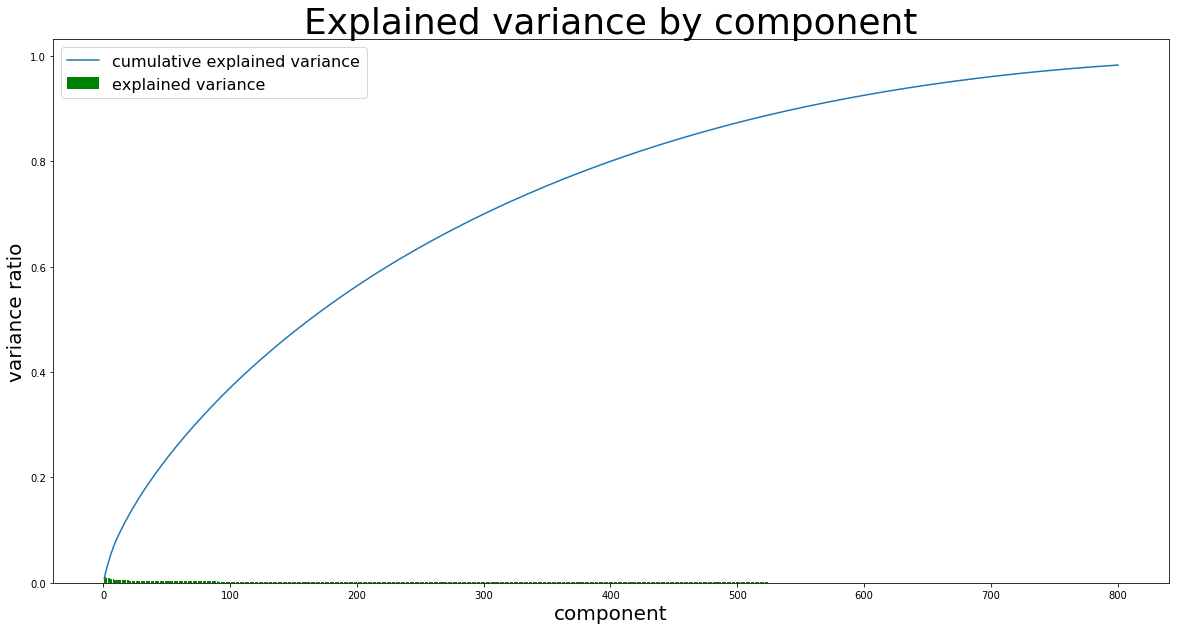

In [29]:
fig = plt.figure(figsize=(20,10))
plt.bar(np.array(range(800))+1, 
        SVD.explained_variance_ratio_, 
        color='g', 
        label='explained variance')
plt.plot(np.array(range(800))+1, 
         np.cumsum(SVD.explained_variance_ratio_), 
         label='cumulative explained variance')
plt.legend(fontsize=16)
plt.xlabel('component', fontsize=20)
plt.ylabel('variance ratio', fontsize=20)
plt.title('Explained variance by component', fontsize=36)
plt.savefig('./images/explained_variance_svd.png')

_At around 700-800 terms we reach 1.0 for the variance explained. That might still be too many components for us to consider, and having about 75% of the variance explained puts us at about 350 or so components. This way, we can have a high amount of variance explained by only using a fraction of the features (the original used 1008 features)._

In [30]:
# We can use numpy and the explained_variance_ratio_ attribute to figure out
# How many components do we need to represent at least 75% of the variance in the data.
np.where(np.cumsum(SVD.explained_variance_ratio_) < .75)[0][-1]+1

346

_I will later refit the data to the SVD model for modeling purposes (with number of components equal to 346), but for now, I will continue to use the current fit to further explore the data._

### Converting the Matrix to a DataFrame for Interpretability

In [31]:
component_names = ["component_"+str(i+1) for i in range(800)]
svd_df = pd.DataFrame(svd_matrix, columns=component_names)
svd_df.shape

(1725, 800)

In [32]:
svd_df.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_791,component_792,component_793,component_794,component_795,component_796,component_797,component_798,component_799,component_800
0,0.026086,-0.030858,0.027112,-0.007769,0.003046,0.004812,-0.020703,-0.009205,-0.019623,0.021069,...,0.000646,-0.019584,-0.008489,-0.017820,0.000775,-0.013390,-0.008134,-0.004729,0.012871,0.003638
1,0.133376,-0.157650,-0.282656,0.072899,-0.140866,-0.269531,0.137043,-0.034375,0.034138,0.022246,...,-0.003406,-0.018942,-0.005203,0.001997,-0.000299,-0.001421,0.005767,-0.020071,-0.027453,-0.019679
2,0.201707,-0.214427,0.316647,-0.010842,-0.033583,-0.089098,0.047588,0.056832,0.083214,-0.202491,...,-0.000674,0.002586,0.006483,-0.030425,-0.008071,0.003722,0.004605,0.001809,0.000599,-0.009286
3,0.145378,-0.144766,0.052564,-0.003165,-0.019350,0.039956,-0.057017,0.007208,0.018431,-0.082722,...,0.012772,-0.025554,0.007735,0.010986,0.013191,0.020074,0.004904,0.006749,-0.012695,-0.006191
4,0.081967,-0.117119,-0.179530,-0.145555,0.074611,-0.111748,0.068965,-0.072985,0.025804,-0.014260,...,-0.002782,0.007367,0.003726,-0.009206,-0.011376,-0.000041,0.029987,-0.005916,0.004769,0.009274


In [33]:
svd_df.shape

(1725, 800)

### Make Feature Loadings Matrix
_We can take a look at how the original 1008 words contributed to the components created (namely, the first two for the sake of EDA)._

In [34]:
# Creating a DataFrame that holds the original components as rows
# compared to the new features as columns
loadings=pd.DataFrame(SVD.components_,index=component_names,columns=term_df.columns).T

# Creating two new columns for the absolute value of components 1 and 2
loadings['abs_component_1'] = np.abs(loadings.component_1)
loadings['abs_component_2'] = np.abs(loadings.component_2)
loadings['abs_component_3'] = np.abs(loadings.component_3)
loadings['abs_component_4'] = np.abs(loadings.component_4)
loadings['abs_component_5'] = np.abs(loadings.component_5)
loadings.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_796,component_797,component_798,component_799,component_800,abs_component_1,abs_component_2,abs_component_3,abs_component_4,abs_component_5
000,0.005069,-0.005367,-0.002498,-0.000979,0.000252,0.006963,-0.006342,-0.002807,-0.002988,0.000506,...,-0.061471,0.054720,-0.020575,-0.000092,-0.037975,0.005069,0.005367,0.002498,0.000979,0.000252
10,0.014550,-0.017831,-0.005128,-0.004160,0.002892,0.008800,-0.011001,-0.008658,-0.002348,-0.000917,...,0.026777,0.047505,0.004730,0.010140,-0.012920,0.014550,0.017831,0.005128,0.004160,0.002892
100,0.010944,-0.005672,-0.008196,-0.003487,0.000996,0.013676,0.021675,-0.000058,0.001861,-0.000735,...,0.001468,-0.002687,0.002195,0.012730,-0.005327,0.010944,0.005672,0.008196,0.003487,0.000996
1000,0.005237,-0.007506,-0.004464,-0.004228,0.001569,-0.000714,0.002579,-0.003227,0.001403,-0.006153,...,-0.002487,0.009459,0.013894,-0.013860,0.017023,0.005237,0.007506,0.004464,0.004228,0.001569
11,0.004322,-0.003868,-0.001724,0.000656,-0.000230,0.011559,0.004442,-0.000448,0.001296,0.003067,...,0.027514,0.022914,-0.051031,0.023790,0.006646,0.004322,0.003868,0.001724,0.000656,0.000230


In [35]:
# Top 10 words that contribute to component 1
loadings.sort_values('abs_component_1',ascending=False).head(10)[['component_1']]

,component_1
call,0.709003
man,0.278099
get,0.198646
one,0.171142
doe,0.146227
name,0.121453
bar,0.115141
go,0.096117
time,0.091166
friend,0.079920


In [36]:
# Top 10 components that contribute to Topic 2
loadings.sort_values('abs_component_2',ascending=False).head(10)[['component_2']]

,component_2
call,0.664860
man,-0.299003
get,-0.290132
one,-0.189473
bar,-0.155230
go,-0.127068
doe,-0.122877
time,-0.088334
drink,-0.081723
well,-0.080286


_It seems that component 1 and component 2 have common words 'man' and 'one', but the word 'call' is positively contributing to component 1 and negatively contributing to component 2. Otherwise, the top words that contributes to component 1 are different from the ones in component 2._

In [37]:
# For further exploration, here are the 
# top 10 words that contribute to components 3, 4, and 5.
loadings.sort_values('abs_component_3',ascending=False).head(10)[['component_3']]

,component_3
man,0.646915
get,-0.493107
doe,-0.296179
bar,0.286010
cross,-0.100885
one,-0.100501
many,-0.089500
take,-0.088543
chicken,-0.084675
bartender,0.083373


In [38]:
loadings.sort_values('abs_component_4',ascending=False).head(10)[['component_4']]

,component_4
coffee,0.623343
doe,0.549508
get,-0.437316
cross,-0.104043
many,0.101774
take,0.088109
chicken,-0.076160
road,-0.074970
lightbulb,0.053972
one,0.052913


In [39]:
loadings.sort_values('abs_component_5',ascending=False).head(10)[['component_5']]

,component_5
coffee,0.724099
doe,-0.534562
get,0.231597
anti,0.127618
many,-0.119272
take,-0.105616
black,0.070809
cross,0.067147
man,-0.057188
lightbulb,-0.056419


### Plotting the First Two Components

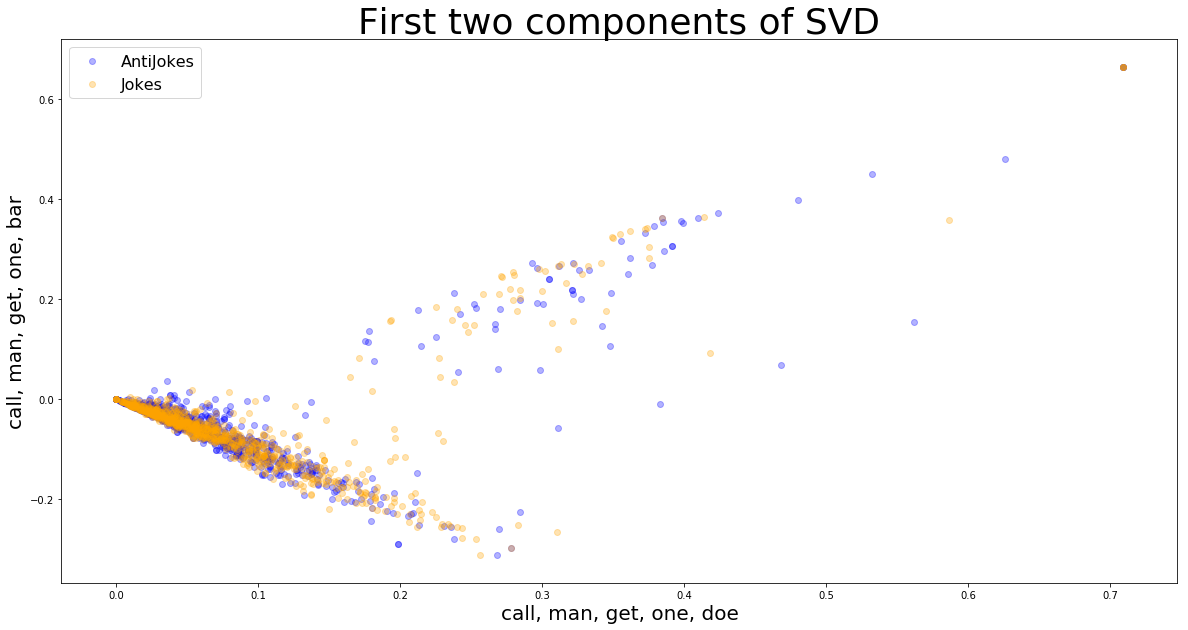

In [40]:
plt.figure(figsize=(20,10))
plt.scatter(svd_df.component_1[target==1], svd_df.component_2[target==1], c='blue', alpha=.3)
plt.scatter(svd_df.component_1[target==0], svd_df.component_2[target==0], c='orange', alpha=.3)
plt.xlabel(f"{', '.join(loadings.sort_values('abs_component_1',ascending=False).head(5)[['component_1']].index)}",
          fontsize=20)
plt.ylabel(f"{', '.join(loadings.sort_values('abs_component_2',ascending=False).head(5)[['component_2']].index)}",
          fontsize=20)
plt.title('First two components of SVD', fontsize=36)
plt.legend(['AntiJokes', 'Jokes'], fontsize=16)
plt.savefig('./images/two_svd.png', bbox_inches='tight')

_There seems to be some separation of data, but not great. Using more components will defeinitely help distringuish between the two classes._

## Preliminary Modeling with KNN
_I use KNN as a preliminary model to establish a baseline accuracy. Currently, the baseline accuracy is around 51%, which the percentage of the majority class._

In [41]:
X_train, X_test, y_train, y_test = train_test_split(svd_df, 
                                                    target, 
                                                    stratify=target, 
                                                    random_state=42)
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

0.5328692962103635
0.4861111111111111


_It doesn't seem that the KNN model has a higher accuracy than our baseline. Using GridSearch to optimize n_neighbors to try to increase accuracy._

In [42]:
%time
gs = GridSearchCV(KNeighborsClassifier(), 
                  {'n_neighbors': np.arange(3,56,6)}, 
                  cv=5, 
                  return_train_score=True)
gs.fit(X_train, y_train)
gs.best_params_

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


{'n_neighbors': 45}

In [43]:
print('GridSearch training score: ', gs.score(X_train,y_train))
print('GridSearch test score: ', gs.score(X_test,y_test))

GridSearch training score:  0.6643464810518175
GridSearch test score:  0.6111111111111112


_Yes! A new baseline score (on the test data) of about 59%! As I continue to use different models, I hope that the baseline score will increase!   
Note: This isn't really a baseline accuracy since we used the SVD fit and transform on the entire dataset (even before splitting into train-test-split) and therefore isn't accurate. However, this score is purely for exploratory purposes, as well as establishing a baseline._